# How to use pysigproc to generate candidates

In [1]:
%matplotlib notebook
from candidate import Candidate
import numpy as np
from scipy.signal import detrend
import bin.h5plotter
import matplotlib.pyplot as plt
import logging
logger = logging.getLogger()
logger = logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(threadName)s - %(levelname)s -'
                                                        ' %(message)s')


In [2]:

import platform

In [3]:
sys = platform.system()
sys

'Windows'

Here is the heimdall output from our file:

S/N, Sample, Time, Width, DM trial, DM, Members, Start Sample, End Sample

88.6941	6305	0.826	1	34	56.838	295	6304	6308

First, we make the candiate object

In [4]:
# creating the candidate object with a certain dm, label, snr, tcand and width
cand = Candidate(fp=f'F:/fast/data/askap_frb_180417/28.fil', dm=56.838, label=1, snr=88.694, tcand=0.826, width=2**1)

None None
None None


In [5]:
# Get data, this will take data from the filterbank file, and can be accessed from cand.data:
cand.get_chunk()
print(cand.data, cand.data.shape,cand.dtype)

<class 'numpy.uint8'> 1 336
[[134 148 148 ... 105 144 108]
 [123 164 133 ... 147 134 113]
 [139 117 127 ... 123 110 153]
 ...
 [110  89 142 ... 120 128 107]
 [136 131 136 ... 145 137 124]
 [108  75 152 ... 162 157 102]] (256, 336) <class 'numpy.uint8'>


In [35]:
cand.tsamp

0.00126646875

<IPython.core.display.Javascript object>


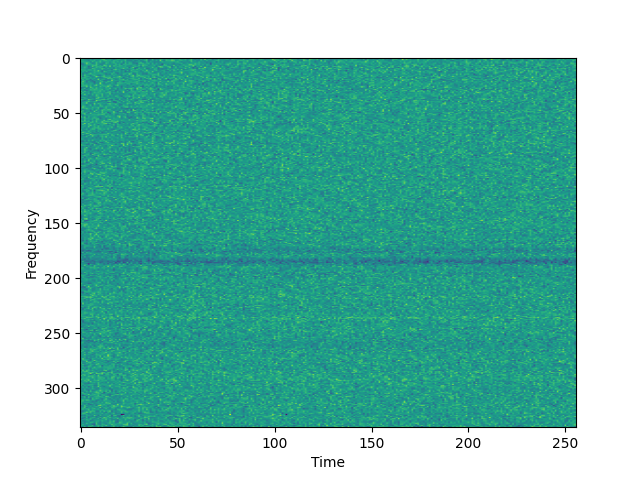

In [11]:
# here is our dispersed pulse
plt.imshow(cand.data.T,aspect='auto',interpolation=None)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

In [12]:
# Now let's make the DM Time plot. This may take a while. 
cand.dmtime()

<IPython.core.display.Javascript object>


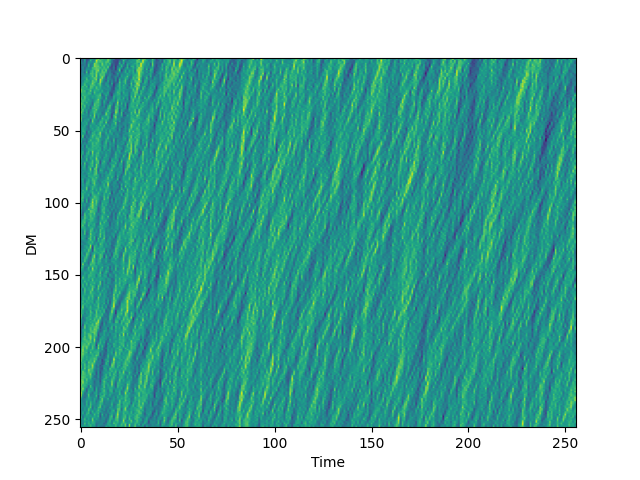

In [13]:
# the DM time plot can be accessed using cand.dmt. Let's have a look: 
plt.imshow(cand.dmt, aspect='auto',interpolation=None)
plt.ylabel('DM')
plt.xlabel('Time')
plt.show()

In [14]:
# Now let's Dedisperse it!
cand.dedisperse()

<IPython.core.display.Javascript object>


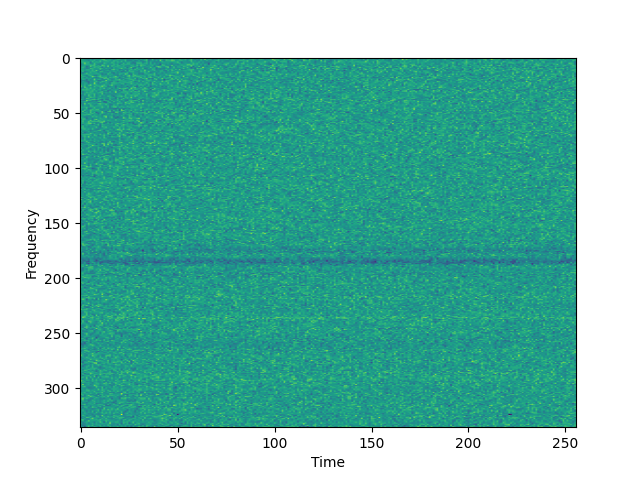

In [15]:
# The dedispersed pulse can be obtained using cand.dedispersed
plt.imshow(cand.dedispersed.T,aspect='auto',interpolation=None)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

<IPython.core.display.Javascript object>


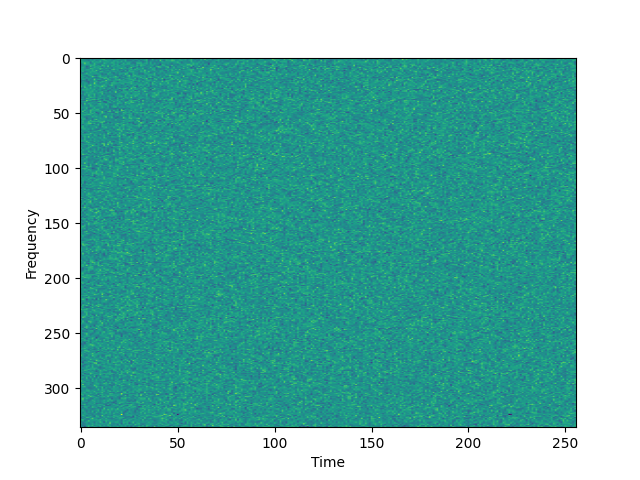

In [16]:
# Detrending can be used to remove bandpass variations
plt.imshow(detrend(cand.dedispersed.T),aspect='auto',interpolation=None)
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.show()

In [17]:
# Optimise dm could be used to obtain accurate value of dm, and snr at that dm (under testing)
cand.optimize_dm()
print(f'Heimdall reported dm: {cand.dm}, Optimised DM: {cand.dm_opt}')
print(f'Heimdall reported snr: {cand.snr}, SNR at Opt. DM: {cand.snr_opt}')

Heimdall reported dm: 56.838, Optimised DM: 1.6149283710563545
Heimdall reported snr: 88.694, SNR at Opt. DM: 2.9038760662078857


In [18]:
# for now, let's enter some random values for dm_opt and snr_opt
cand.dm_opt = -1
cand.snr_opt = -1

In [19]:
# Name of the candidate
cand.id

'cand_tstart_58682.620316710374_tcand_0.8260000_dm_56.83800_snr_88.69400'

In [20]:
# Now let's save our candidate in an h5
fout=cand.save_h5()
print(fout) 

cand_tstart_58682.620316710374_tcand_0.8260000_dm_56.83800_snr_88.69400.h5


<IPython.core.display.Javascript object>


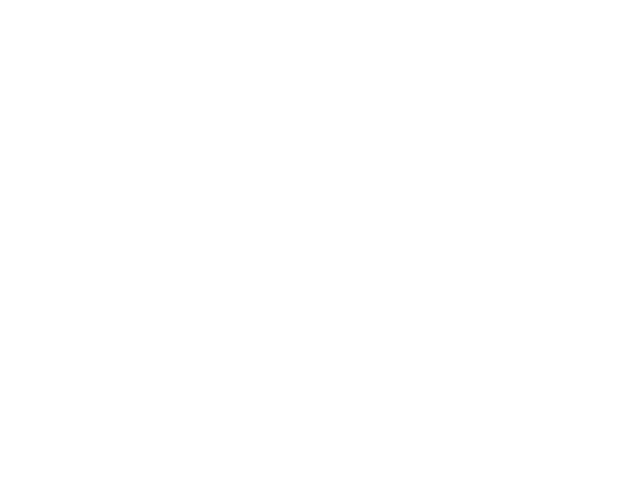

<IPython.core.display.Javascript object>


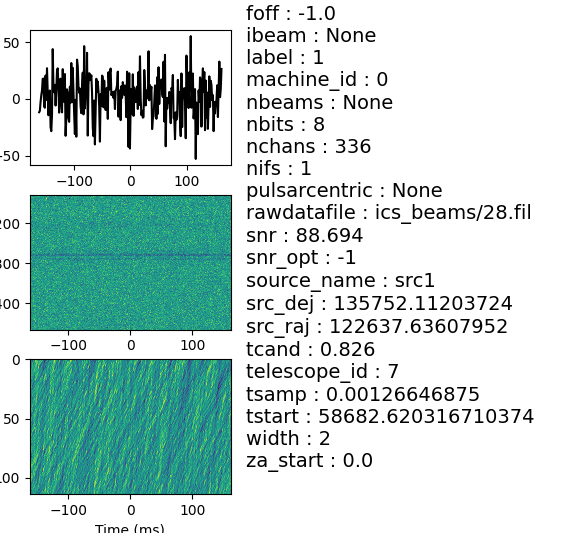

'cand_tstart_58682.620316710374_tcand_0.8260000_dm_56.83800_snr_88.69400.png'

In [23]:
# We will use h5plotter to plot the candidate h5 we just generated
import bin.h5plotter as h5plotter

h5plotter.plot_h5(fout, show=True, detrend=False, save=False)

# Reshaping Freq-time and DM-time arrays

In [24]:
dedispersed_bkup = cand.dedispersed
dmt_bkup = cand.dmt

In [25]:
print(f'Shape of dedispersed (frequency-time) data: {dedispersed_bkup.T.shape}')
print(f'Shape of DM-time data: {dmt_bkup.shape}')

Shape of dedispersed (frequency-time) data: (336, 256)
Shape of DM-time data: (256, 256)


In [26]:
time_size = 256
freq_size = 256

# Using resize in skimage.transform for reshaping

In [27]:
#resize dedispersed Frequency-time array along time axis
cand.resize(key='ft', size=time_size, axis=0, anti_aliasing=True)

#resize dedispersed Frequency-time array along time axis
cand.resize(key='ft', size=freq_size, axis=1, anti_aliasing=True)
logging.info(f'Resized Frequency-Time data to fsize: {freq_size} and tsize: {time_size}')

print(f'Shape of dedispersed (frequency-time) data: {cand.dedispersed.T.shape}')

2021-09-29 16:08:11,576 - root - MainThread - INFO - Resized Frequency-Time data to fsize: 256 and tsize: 256


Shape of dedispersed (frequency-time) data: (256, 256)


In [28]:
#resize DM-time array along time axis
cand.resize(key='dmt', size = time_size, axis=1, anti_aliasing=True)
logging.info(f'Resized DM-Time to dmsize: 256 and tsize: {time_size}')
print(f'Shape of DM-time data: {cand.dmt.shape}')

2021-09-29 16:08:14,977 - root - MainThread - INFO - Resized DM-Time to dmsize: 256 and tsize: 256


Shape of DM-time data: (256, 256)


# Using decimate for reshaping

In [29]:
from candidate import crop

In [30]:
cand.dedispersed = dedispersed_bkup
cand.dmt = dmt_bkup

In [31]:
# Let's use pulse width to decide the decimate factor by which to collape the time axis
pulse_width = cand.width
if pulse_width == 1:
    time_decimate_factor = 1
else:
    time_decimate_factor = pulse_width // 2  

# Decimating time axis, and cropping to the final size
cand.decimate(key='ft', axis=0, pad=True, decimate_factor=time_decimate_factor, mode='median')
crop_start_sample_ft = cand.dedispersed.shape[0] // 2 - time_size // 2
cand.dedispersed = crop(cand.dedispersed, crop_start_sample_ft, time_size, 0)

# Decimating frequency axis
cand.decimate(key='ft', axis=1, pad=True, decimate_factor=cand.dedispersed.shape[1]//freq_size, mode='median')
logging.info(f'Decimated Frequency-Time data to fsize: {freq_size} and tsize: {time_size}')

print(f'Shape of dedispersed (frequency-time) data: {cand.dedispersed.T.shape}')

2021-09-29 16:08:17,662 - root - MainThread - INFO - Decimated Frequency-Time data to fsize: 256 and tsize: 256


Shape of dedispersed (frequency-time) data: (336, 256)


In [32]:
# Reshaping the DM-time using decimation
# Decimating time axis and croppig to the final required size 
cand.decimate(key='dmt', axis=1, pad=True, decimate_factor=time_decimate_factor, mode='median')
crop_start_sample_dmt = cand.dmt.shape[1] // 2 - time_size // 2
cand.dmt = crop(cand.dmt, crop_start_sample_dmt, time_size, 1)
logging.info(f'Decimated DM-Time to dmsize: 256 and tsize: {time_size}')
print(f'Shape of DM-time data: {cand.dmt.shape}')

2021-09-29 16:08:18,234 - root - MainThread - INFO - Decimated DM-Time to dmsize: 256 and tsize: 256


Shape of DM-time data: (256, 256)
